In [8]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 
from statistics import mean
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import seaborn as sns
import networkx as nx


## Training Data

In [9]:
df = pd.DataFrame()
f = yf.download(tickers = "RELIANCE.NS",
                       start = '2022-01-01',
                       end = '2023-01-01',)

#df = f[[("Adj Close", s) for s in list_of_stocks]]
df = f[["Adj Close"]]
#df.columns = df.columns.droplevel(level=0)
df

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2022-01-03,2396.634521
2022-01-04,2450.721680
2022-01-05,2462.187012
2022-01-06,2409.246338
2022-01-07,2428.687988
...,...
2022-12-26,2524.050049
2022-12-27,2544.699951
2022-12-28,2544.449951


In [10]:
#convert to numpy array for neural network to take input 

#print(type(df))
training_set = f.iloc[:,4:5].values
#print(type(df))

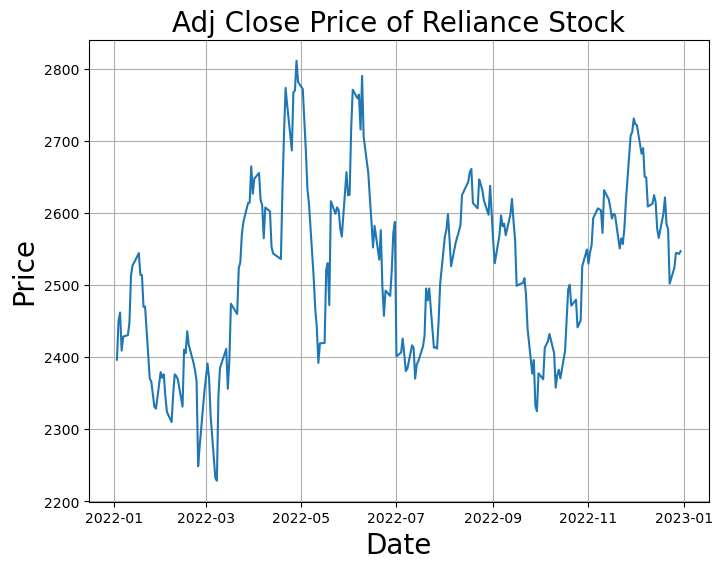

In [11]:
plt.figure(figsize=(8,6))
plt.plot(df)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Price", fontsize = 20)
plt.title("Adj Close Price of Reliance Stock", fontsize = 20)
plt.grid(True)
plt.show()

In [12]:
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [33]:
#Lag = 15 -( 3 weeks )
#Train the model on 15 day data
timestep = 15
x_train_a = []
y_train_a = []
for i in range(15, len(training_set_scaled)):
    x_train_a.append(training_set_scaled[i-timestep: i, 0])
    y_train_a.append(training_set_scaled[i])

x_train_a, y_train_a = np.array(x_train_a), np.array(y_train_a)

In [14]:
N = len(y_train_a)

In [15]:
N #Total number of inputs

233

In [18]:
y_train_a.shape

(233, 1)

In [19]:
 ## make model 
# instntiate model
my_model = Sequential()

# add layers 

#layer 1
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu", input_shape = (x_train_a.shape[1] ,1)))
my_model.add(Dropout(rate = 0.2))

#layer 2
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu"))
my_model.add(Dropout(rate = 0.2))


#layer 3
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu"))
my_model.add(Dropout(rate = 0.2))

#layer 4
my_model.add(SimpleRNN(units = 50, return_sequences = False, activation = "relu"))
my_model.add(Dropout(rate = 0.2))

#output layer 
my_model.add(Dense(units = 1))

## compile model 
my_model.compile(optimizer = "adam", loss = "mean_squared_error")
    

In [20]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 15, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 15, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 15, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 15, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

## Fit Model

In [21]:
# METHOD 1: ONLY SAVES 1 LAYER, ALL WEIGHTS 
# use callback function to get weights after every epoch 
from keras.callbacks import Callback

class CollectWeightCallback(Callback):
    def __init__(self, layer_index):
        super(CollectWeightCallback, self).__init__()
        self.layer_index = layer_index
        self.weights = []

    def on_epoch_end(self, epoch, logs=None):
        layer = self.model.layers[self.layer_index]
        self.weights.append(layer.get_weights()[0]) # [0] - get weight only, no biases

In [22]:
numEpochs = 100
numBatch = 20

In [23]:
cbk0 = CollectWeightCallback(layer_index=0) # 0 = 1st layer 
cbk2 = CollectWeightCallback(layer_index=2) # 2 = 2nd layer or 1st dense layer 
cbk4 = CollectWeightCallback(layer_index=4) # 4 = 3rd layer or 2nd dense layer 
cbk6 = CollectWeightCallback(layer_index=6) # 6 = 4th layer or 3rd dense layer 
cbk8 = CollectWeightCallback(layer_index=8) # 8 = last layer 
my_model.fit(x_train_a, y_train_a, epochs = numEpochs, callbacks=[cbk0, cbk2, cbk4, cbk6, cbk8], batch_size = numBatch)

Epoch 1/100
12/12 [==============================] - 7s 16ms/step - loss: 0.1056
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0379
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0324
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0332
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0295
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0236
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0196
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0182
Epoch 11/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0212
Epoch 12/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 13/100
12/12 [=========

## Test Model

In [24]:
df2 = pd.DataFrame()
f2 = yf.download(tickers = "RELIANCE.NS",
                       start = '2023-01-01',
                       end = '2023-01-31',)

#df = f[[("Adj Close", s) for s in list_of_stocks]]
df2 = f2[["Adj Close"]]
#df.columns = df.columns.droplevel(level=0)
df2

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2023-01-02,2575.899902
2023-01-03,2557.050049
2023-01-04,2518.550049
2023-01-05,2514.050049
2023-01-06,2536.899902
2023-01-09,2596.800049
2023-01-10,2558.399902
2023-01-11,2526.149902
2023-01-12,2471.600098


In [26]:
test_set = f2.iloc[:,4:5].values

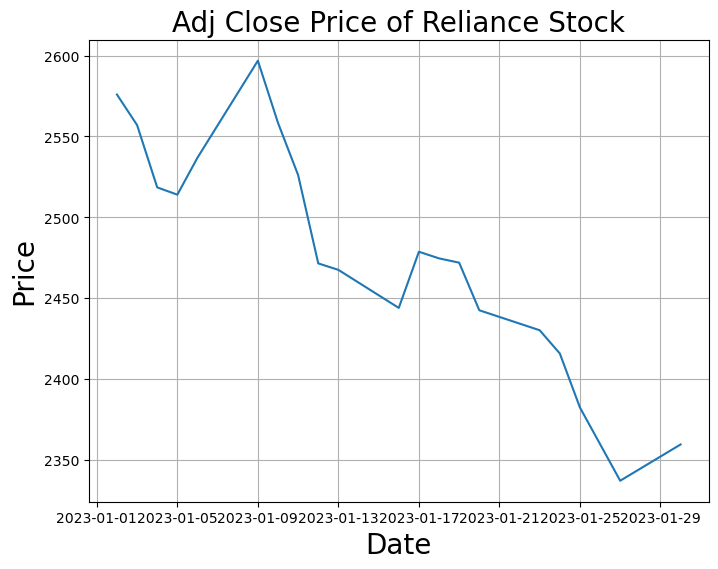

In [27]:
plt.figure(figsize=(8,6))
plt.plot(df2)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Price", fontsize = 20)
plt.title("Adj Close Price of Reliance Stock", fontsize = 20)
plt.grid(True)
plt.show()

In [72]:
test_set_scaled = scaler.transform(test_set)

In [73]:
len(test_set_scaled)

20

In [74]:
full_dataset = pd.concat((df, df2), axis = 0)
inputs = full_dataset[len(full_dataset) - len(test_set) - timestep:].values.reshape(-1,1)
inputs = scaler.transform(inputs)
inputs

array([[0.65965152],
       [0.68007717],
       [0.66377085],
       [0.60000469],
       [0.57811989],
       [0.63596435],
       [0.6745846 ],
       [0.61056073],
       [0.59906056],
       [0.46929636],
       [0.50680108],
       [0.54224572],
       [0.5418166 ],
       [0.53984285],
       [0.54653685],
       [0.59579904],
       [0.56344411],
       [0.49736057],
       [0.48963652],
       [0.52885728],
       [0.63167321],
       [0.56576107],
       [0.51040538],
       [0.41677307],
       [0.40990725],
       [0.36957055],
       [0.42913147],
       [0.42209383],
       [0.41754539],
       [0.36708135],
       [0.34588338],
       [0.32125207],
       [0.26392263],
       [0.18633893],
       [0.22478736]])

In [75]:
x_test = []
for i in range(timestep, len(inputs)):
    x_test.append(inputs[i - timestep:i, 0])

In [76]:
x_test = np.array(x_test)

In [77]:
len(x_test)

20

In [78]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [81]:
predicted_stock_price = my_model.predict(x_test)

1/1 [==============================] - 3s 3s/step


In [82]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [86]:
real_stock_price = df2.values

In [87]:
## function for creating dataset
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Model Accuracy

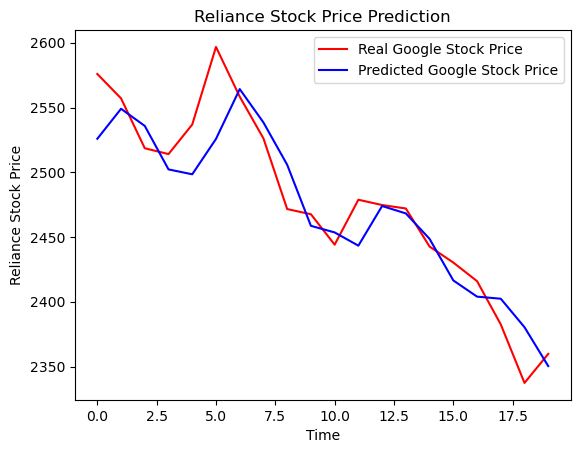

In [88]:
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend()
plt.show()

## Get Weights 

Make Indices

In [ ]:
m = 50 # no. of neurons in a hidden layer 
p = 50
index_neuron = [] 
weights_neuron = []
for i in range(50):
    index_neuron.append("Neuron " + str(i+1))
    weights_neuron.append("W" + str(i+1))

In [ ]:
n = 0 # weights for n+1th epoch
# hidden layer 1
df01 = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
df01 = df01.transpose()
# hidden layer 2
df02 = pd.DataFrame(cbk4.weights[n], index = index_neuron , columns = weights_neuron)
df02 = df02.transpose()
# hidden layer 3
df03 = pd.DataFrame(cbk6.weights[n], index = index_neuron , columns = weights_neuron)
df03 = df03.transpose()

#### Checking correlation among different layers 

In [ ]:
new_df01 = [df01, df02, df03]
df_layer = pd.concat(new_df01, axis = 1, keys = ["L1", "L2", "L3"])

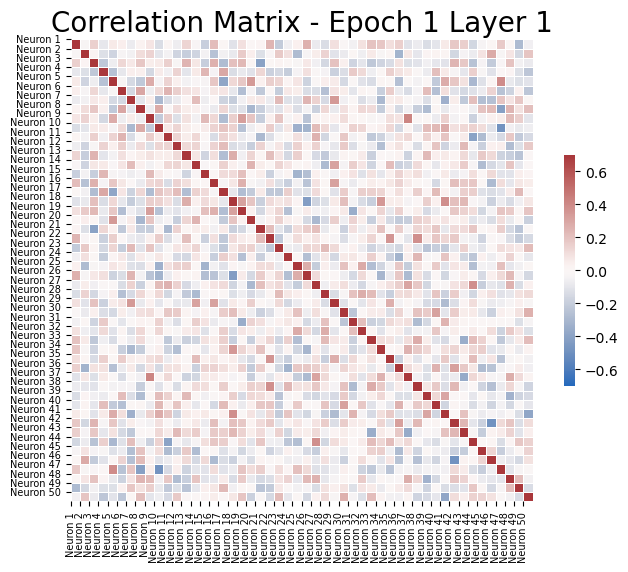

In [ ]:
cor_mat01 = df01.corr() # correlations
f, ax = plt.subplots(figsize = (8,6)) # figure
cmap = sns.color_palette("vlag", as_cmap = True) # colour 
sns.heatmap(
    cor_mat01, # correlations
    cmap = cmap, # colour 
    #annot = True, # show values in cells? 
    vmax = 0.7, # max value on legend, >= .7 will be same color
    vmin = -0.7, # min value on the legend, <= .7 will be same color 
    square = True, # Force cells to be square 
    linewidth = .5, # width of lines that divide cells 
    cbar_kws = {"shrink": .5}
)
plt.xticks(range(df01.select_dtypes(['number']).shape[1]), df01.select_dtypes(['number']).columns, fontsize=7, rotation=90)
plt.yticks(range(df01.select_dtypes(['number']).shape[1]), df01.select_dtypes(['number']).columns, fontsize=7)
plt.title('Correlation Matrix - Epoch 1 Layer 1', fontsize=20);

In [ ]:
n = 99 # weights for n+1th epoch
# hidden layer 1
df99 = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
df99 = df99.transpose()

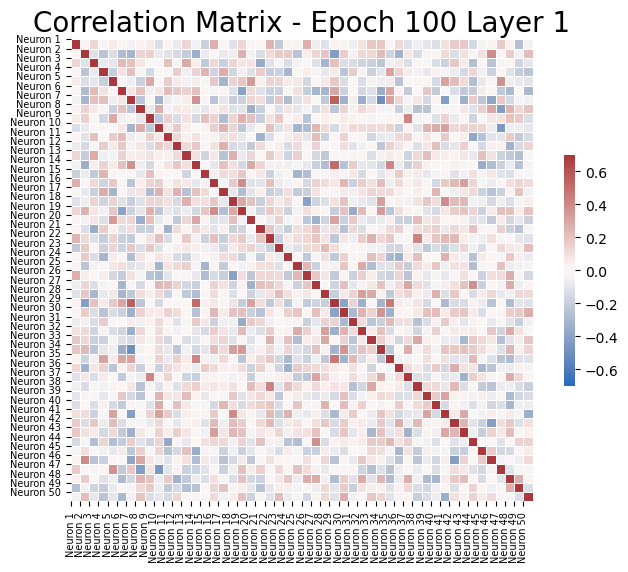

In [ ]:
cor_mat = df99.corr() # correlations
f, ax = plt.subplots(figsize = (8,6)) # figure
cmap = sns.color_palette("vlag", as_cmap = True) # colour 
sns.heatmap(
    cor_mat, # correlations
    cmap = cmap, # colour 
    #annot = True, # show values in cells? 
    vmax = 0.7, # max value on legend, >= .7 will be same color
    vmin = -0.7, # min value on the legend, <= .7 will be same color 
    square = True, # Force cells to be square 
    linewidth = .5, # width of lines that divide cells 
    cbar_kws = {"shrink": .5}
)
plt.xticks(range(df99.select_dtypes(['number']).shape[1]), df99.select_dtypes(['number']).columns, fontsize=7, rotation=90)
plt.yticks(range(df99.select_dtypes(['number']).shape[1]), df99.select_dtypes(['number']).columns, fontsize=7)
plt.title('Correlation Matrix - Epoch 100 Layer 1', fontsize=20);

Graph of Neurons in Layer 1 Epoch 1

### Graphs

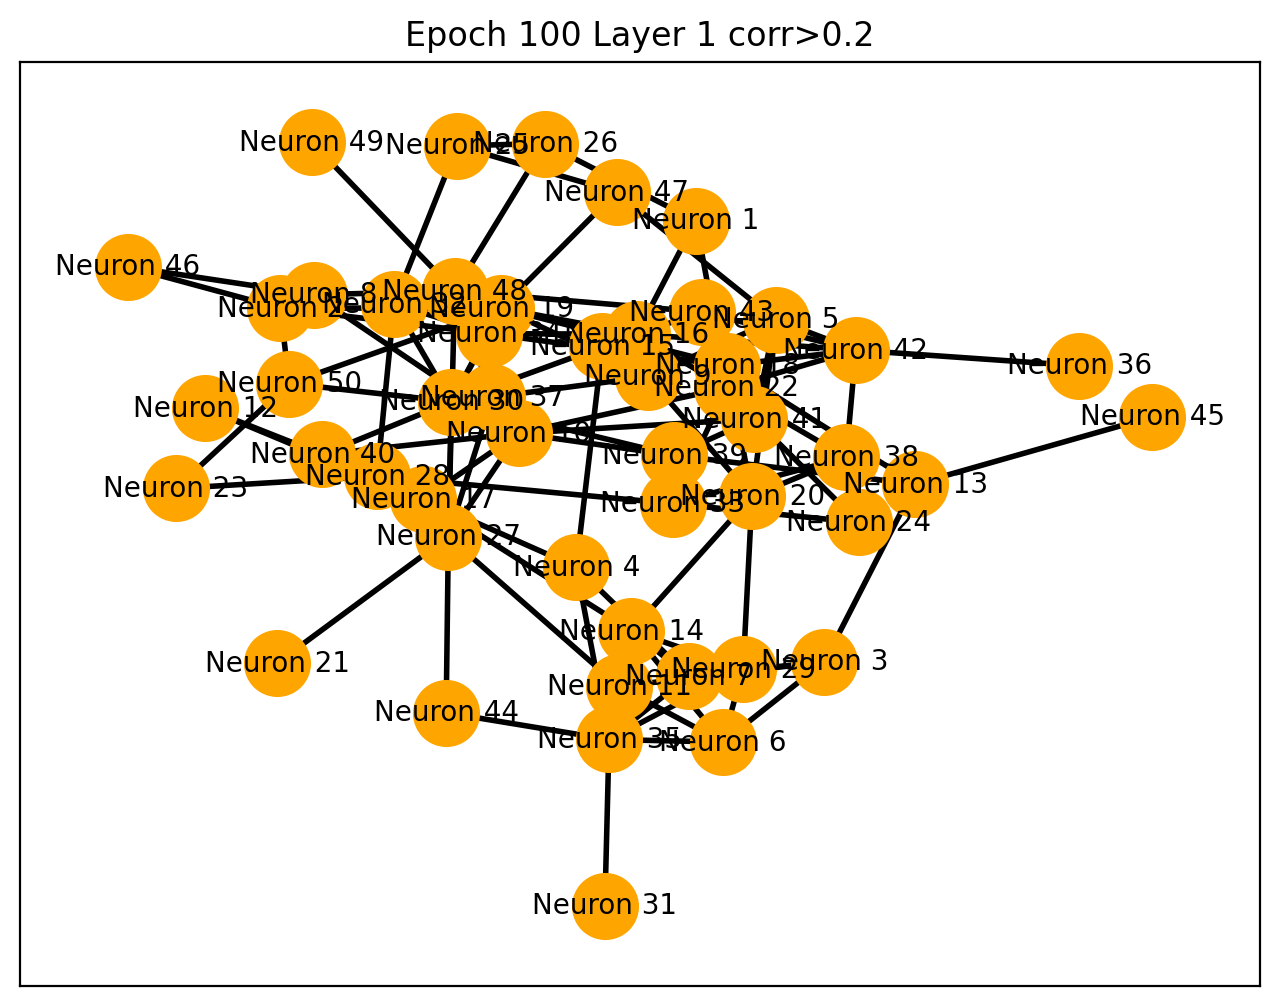

In [ ]:
# make an edge list 

# converts lower triangular matrix to 0
cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

# creating edge list 
links = cor_mat.stack().reset_index()
links.columns = ['Neuron A', 'Neuron B', 'Value'] 
#drop the rows with 0 in Value 
rows_zero = links.loc[links['Value'] == 0.0]
links = links.drop(rows_zero.index)

# save values with correlation more than 0.2
links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

# make the graph 
G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G) 
# spectral layout helps us see how the community structure or other forms of structure in the graph. 
# It uses eigen vectors and eigen values to position the nodes. 

# plot the graph 
plt.figure(figsize=(8,6), dpi=200)
nx.draw_networkx(G, pos, with_labels=True, node_color='orange', width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
plt.title('Epoch 100 Layer 1 corr>0.2')
plt.show()

In [ ]:
# make network grah
def make_graph_h1(correlation_value, epoch_num=99):

    df99 = pd.DataFrame(cbk2.weights[epoch_num], index = index_neuron , columns = weights_neuron)
    df99 = df99.transpose()
    cor_mat = df99.corr() # correlation matrix 
    
    # make a for loop for graph layout
    p = correlation_value
    # make an edge list 

    # converts lower triangular matrix to 0
    cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

    # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    #drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(p)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G) 
    # spectral layout helps us see how the community structure or other forms of structure in the graph. 
    # It uses eigen vectors and eigen values to position the nodes. 

    # communities
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)

    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    # colour map based on communities
    color_map = []
    for node in G:
        if node in result[0]:
            color_map.append("green")
        elif node in result[1]:
            color_map.append("red")
        elif node in result[2]:
            color_map.append("blue")
        elif node in result[3]:
            color_map.append("yellow")
        else:
            color_map.append("orange")

    # plot the graph 
    plt.figure(figsize=(8,6), dpi=100)
    nx.draw_networkx(G, pos, with_labels=True, node_color=color_map, width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
    plt.title('Epoch 100 Layer 1 corr > ' + str(p))
    plt.show()
    return G

In [ ]:
# make network grah
def make_graph_h2(correlation_value, epoch_num=99):

    df99 = pd.DataFrame(cbk4.weights[epoch_num], index = index_neuron , columns = weights_neuron)
    df99 = df99.transpose()
    cor_mat = df99.corr() # correlation matrix 
    
    # make a for loop for graph layout
    p = correlation_value
    # make an edge list 

    # converts lower triangular matrix to 0
    cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

    # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    #drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(p)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G) 
    # spectral layout helps us see how the community structure or other forms of structure in the graph. 
    # It uses eigen vectors and eigen values to position the nodes. 

    # communities
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)

    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    # colour map based on communities
    color_map = []
    for node in G:
        if node in result[0]:
            color_map.append("green")
        elif node in result[1]:
            color_map.append("red")
        elif node in result[2]:
            color_map.append("blue")
        elif node in result[3]:
            color_map.append("yellow")
        else:
            color_map.append("orange")

    # plot the graph 
    plt.figure(figsize=(8,6), dpi=100)
    nx.draw_networkx(G, pos, with_labels=True, node_color=color_map, width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
    plt.title('Epoch 100 Layer 1 corr > ' + str(p))
    plt.show()
    return G

In [ ]:
# make network grah
def make_graph_h3(correlation_value, epoch_num=99):

    df99 = pd.DataFrame(cbk6.weights[epoch_num], index = index_neuron , columns = weights_neuron)
    df99 = df99.transpose()
    cor_mat = df99.corr() # correlation matrix 
    
    # make a for loop for graph layout
    p = correlation_value
    # make an edge list 

    # converts lower triangular matrix to 0
    cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

    # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    #drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(p)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G) 
    # spectral layout helps us see how the community structure or other forms of structure in the graph. 
    # It uses eigen vectors and eigen values to position the nodes. 

    # communities
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)

    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    # colour map based on communities
    color_map = []
    for node in G:
        if node in result[0]:
            color_map.append("green")
        elif node in result[1]:
            color_map.append("red")
        elif node in result[2]:
            color_map.append("blue")
        elif node in result[3]:
            color_map.append("yellow")
        else:
            color_map.append("orange")

    # plot the graph 
    plt.figure(figsize=(8,6), dpi=100)
    nx.draw_networkx(G, pos, with_labels=True, node_color=color_map, width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
    plt.title('Epoch 100 Layer 1 corr > ' + str(p))
    plt.show()
    return G

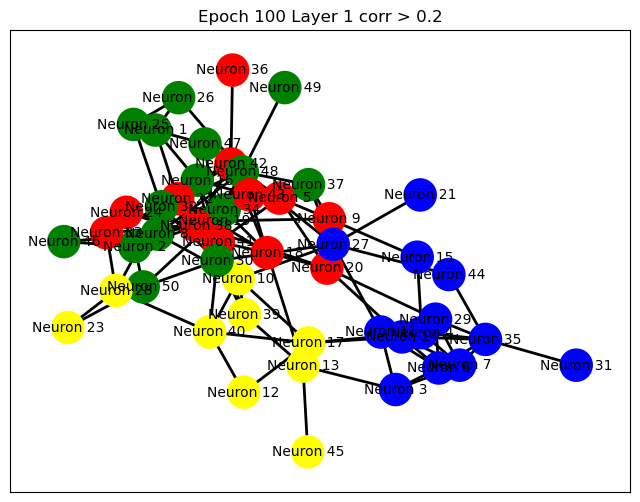

In [ ]:
p1 = make_graph_h1(0.2)

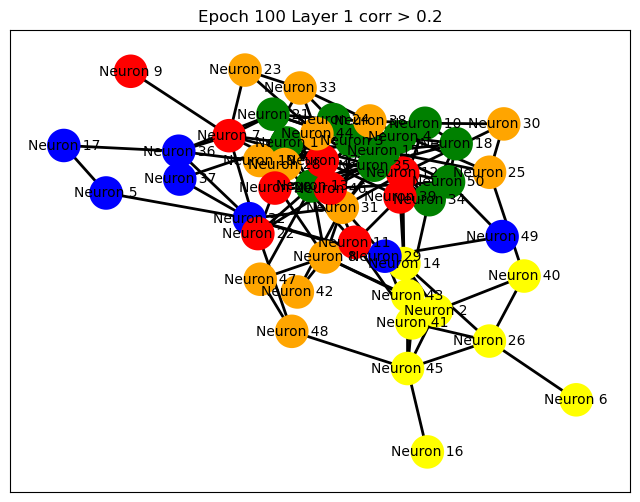

In [ ]:
p2 = make_graph_h2(0.2)

## Graph with communities using Louvain

### Modularity - Using Louvain Algorithm

# The Modularity Function - Change over time - Layer 1

In [ ]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose() 
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch.append(df)

In [ ]:
# finding modularity for each matrix 
modularity_layer1 = []
communities_layer1 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 

    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer1.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer1.append(modularity)

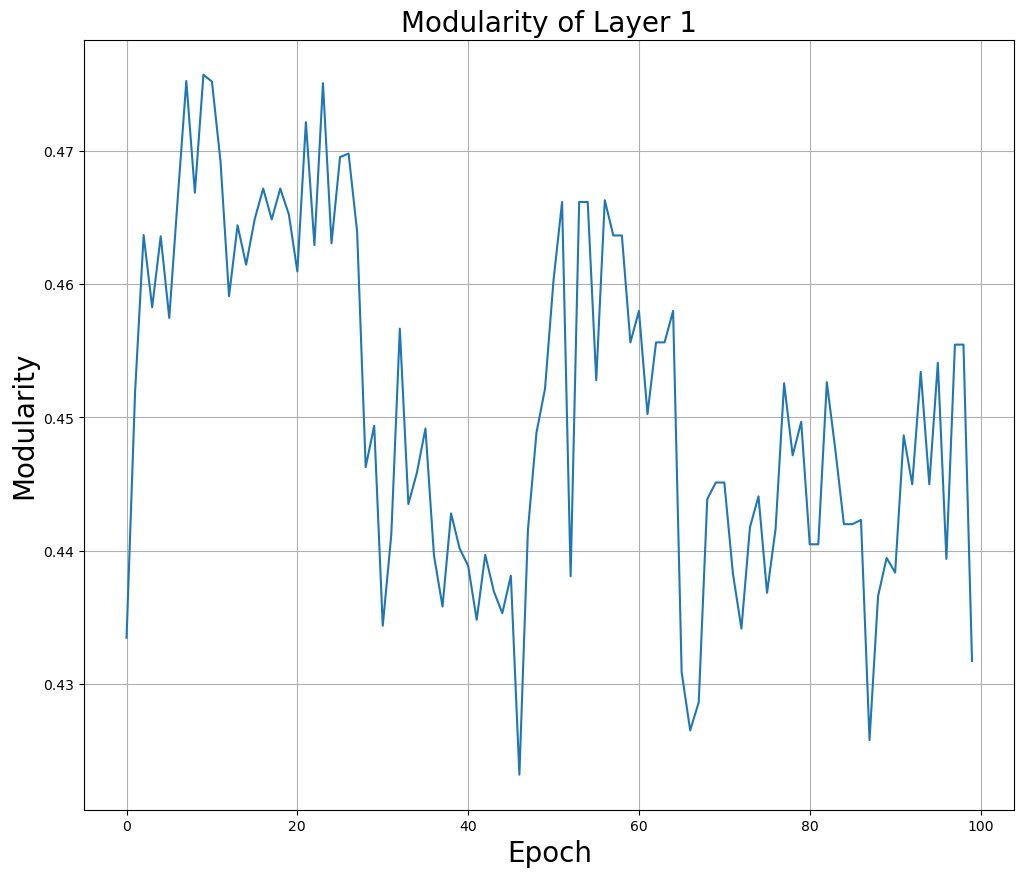

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer1)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 1", fontsize = 20)
plt.grid(True)
plt.show()

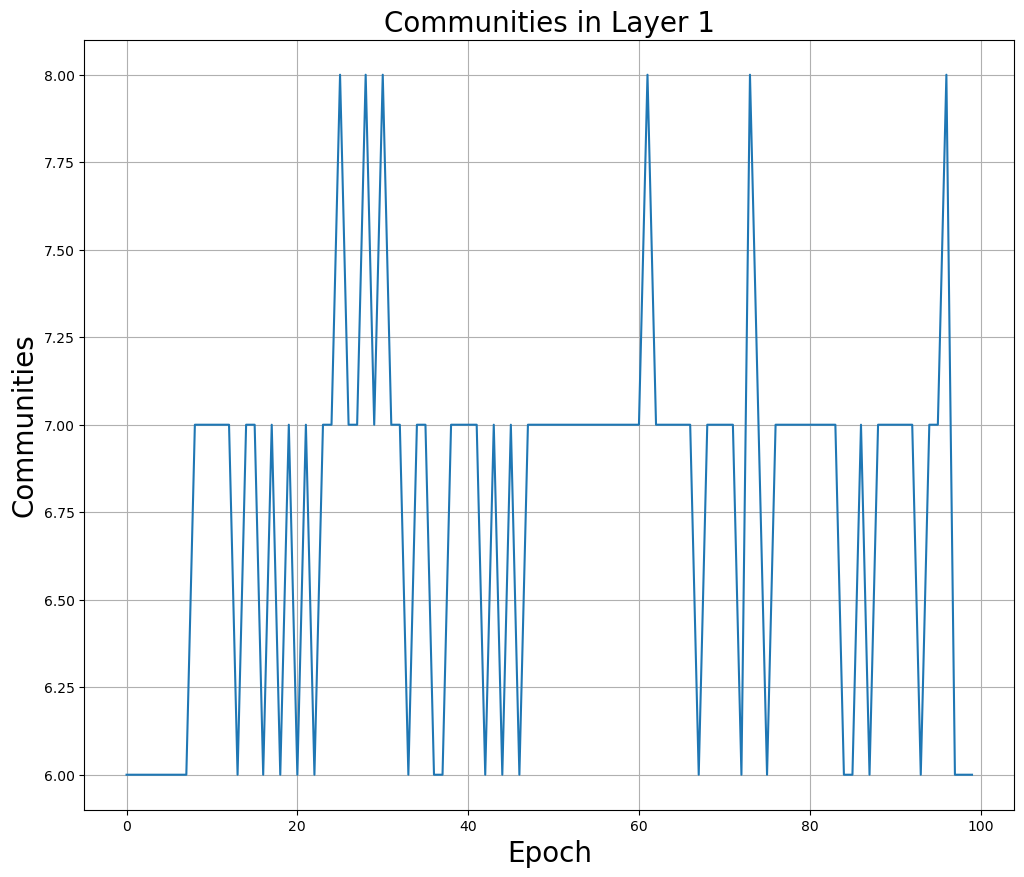

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer1)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 1", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity - Layer 2  

In [ ]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch_l2 = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk4.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose() 
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch_l2.append(df)

In [ ]:
# finding modularity for each matrix 
modularity_layer2 = []
communities_layer2 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch_l2[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 
    
    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer2.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer2.append(modularity)

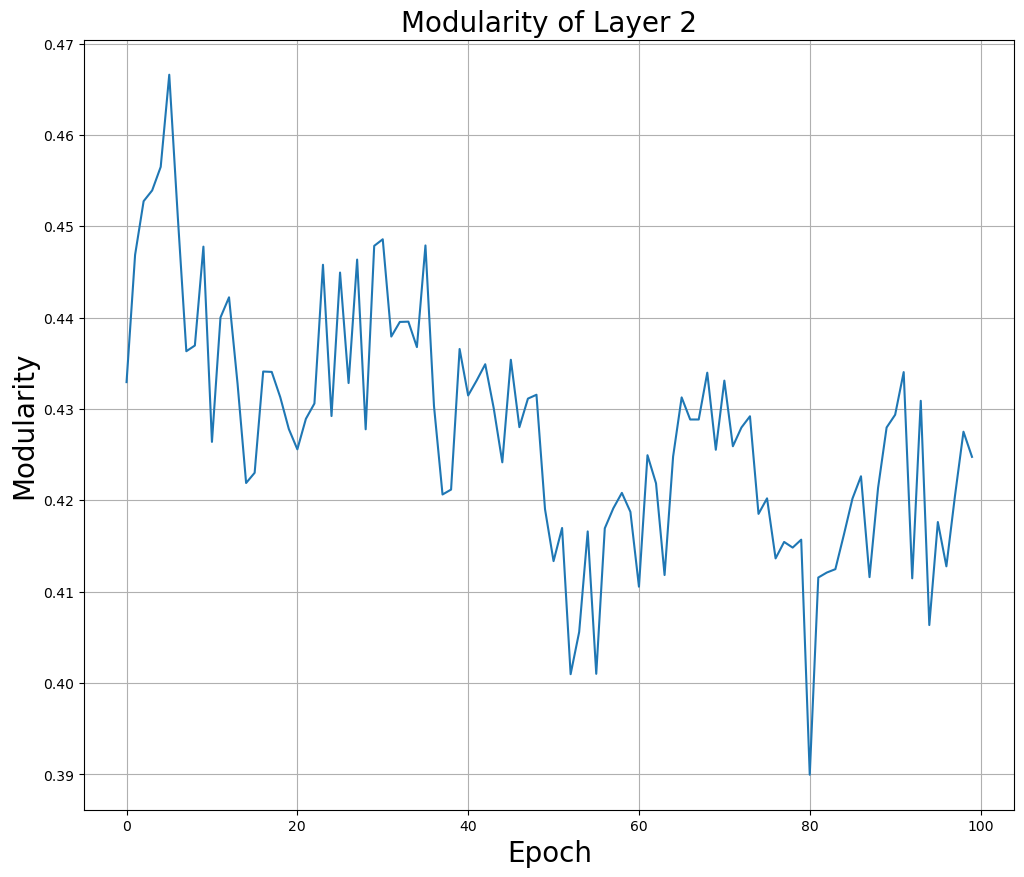

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer2)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 2", fontsize = 20)
plt.grid(True)
plt.show()

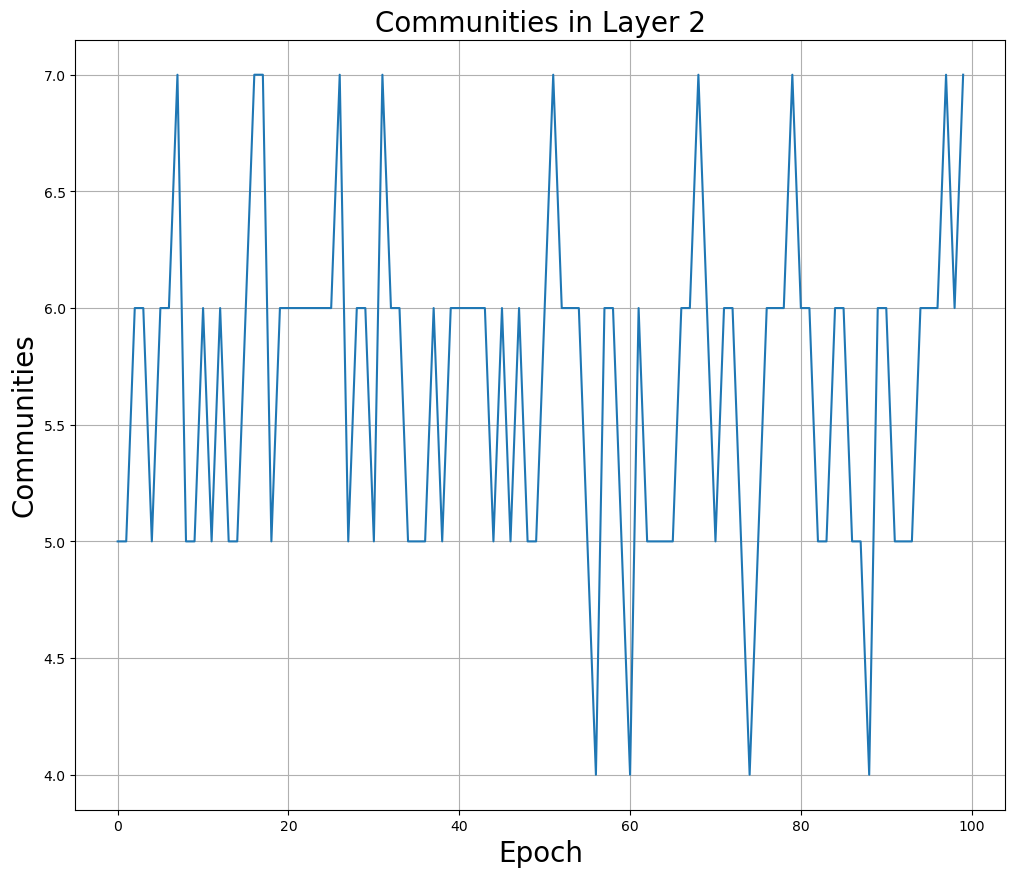

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer2)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 2", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity Function - Change Over Time - Layer 3

In [ ]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch_l3 = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk6.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose()
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch_l3.append(df)

In [ ]:
# finding modularity for each matrix 
modularity_layer3 = []
communities_layer3 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch_l3[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 

    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer3.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer3.append(modularity)

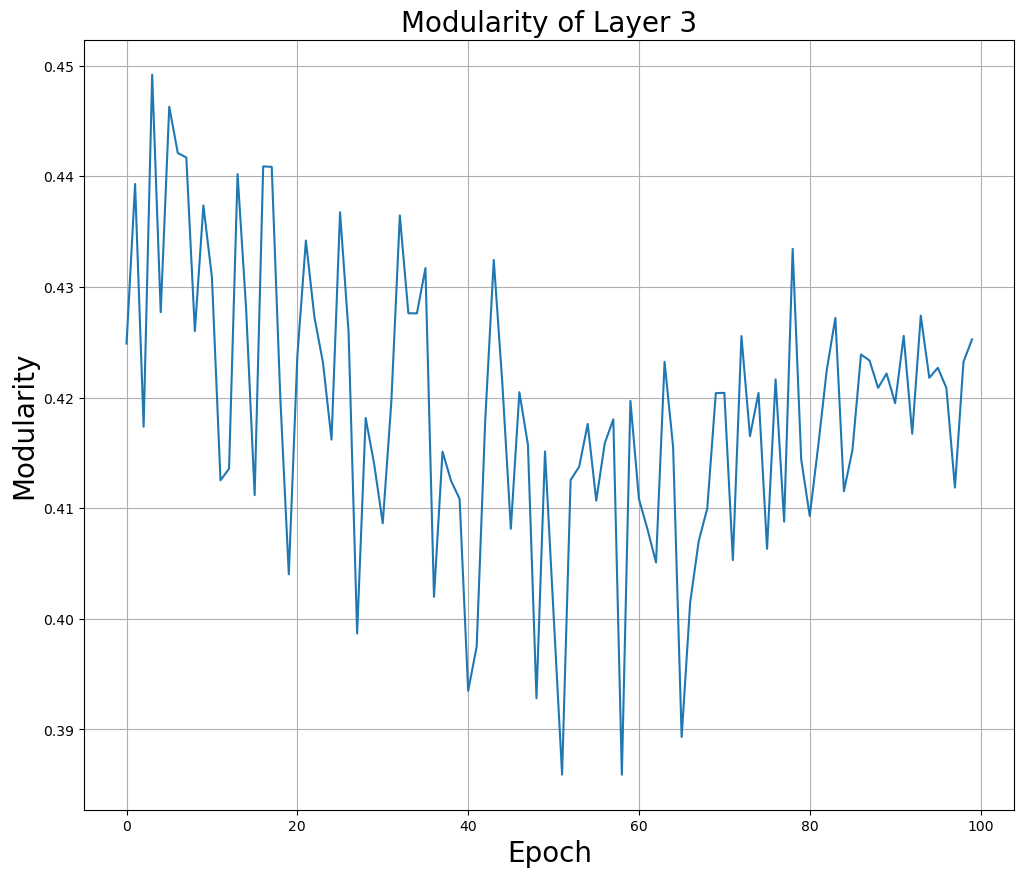

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 3", fontsize = 20)
#ax2 = plt.twiny()
#ax2.plot(pd.Series(np.random.uniform(10, 20, size=10)), color='r')
#ax2.grid(None)
plt.grid(True)
plt.show()

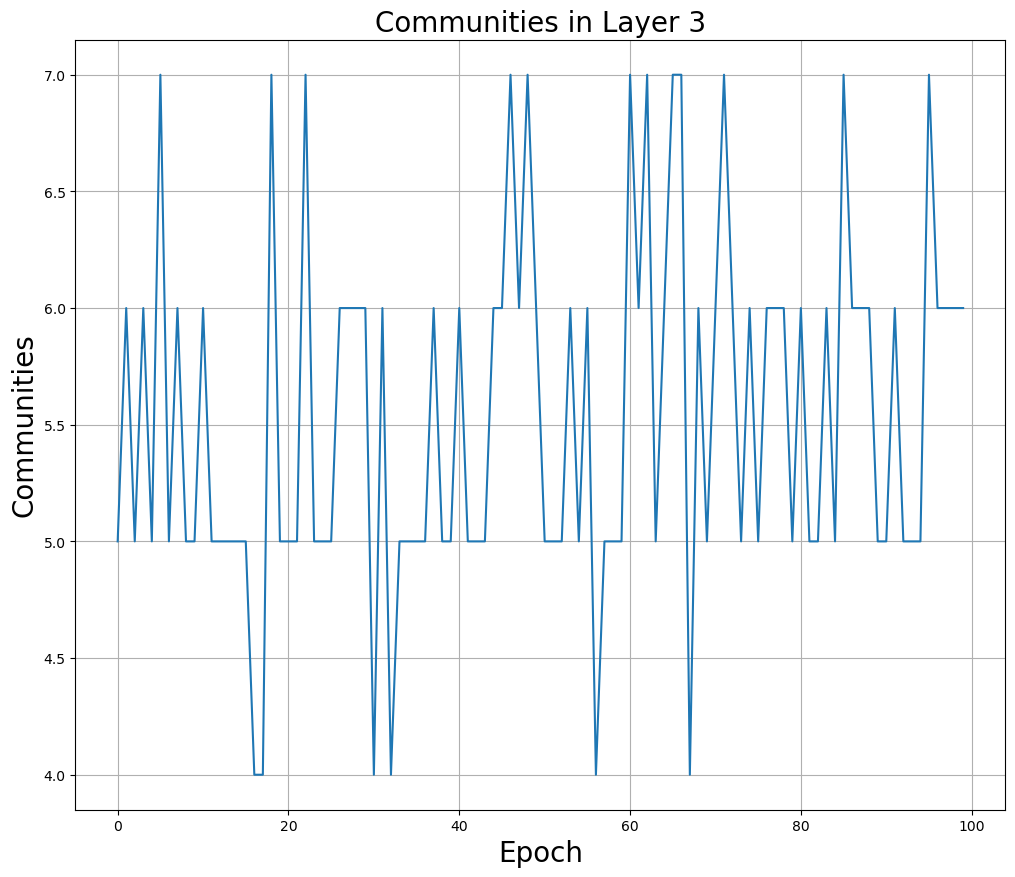

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 3", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity Function - Change over time - all layers 

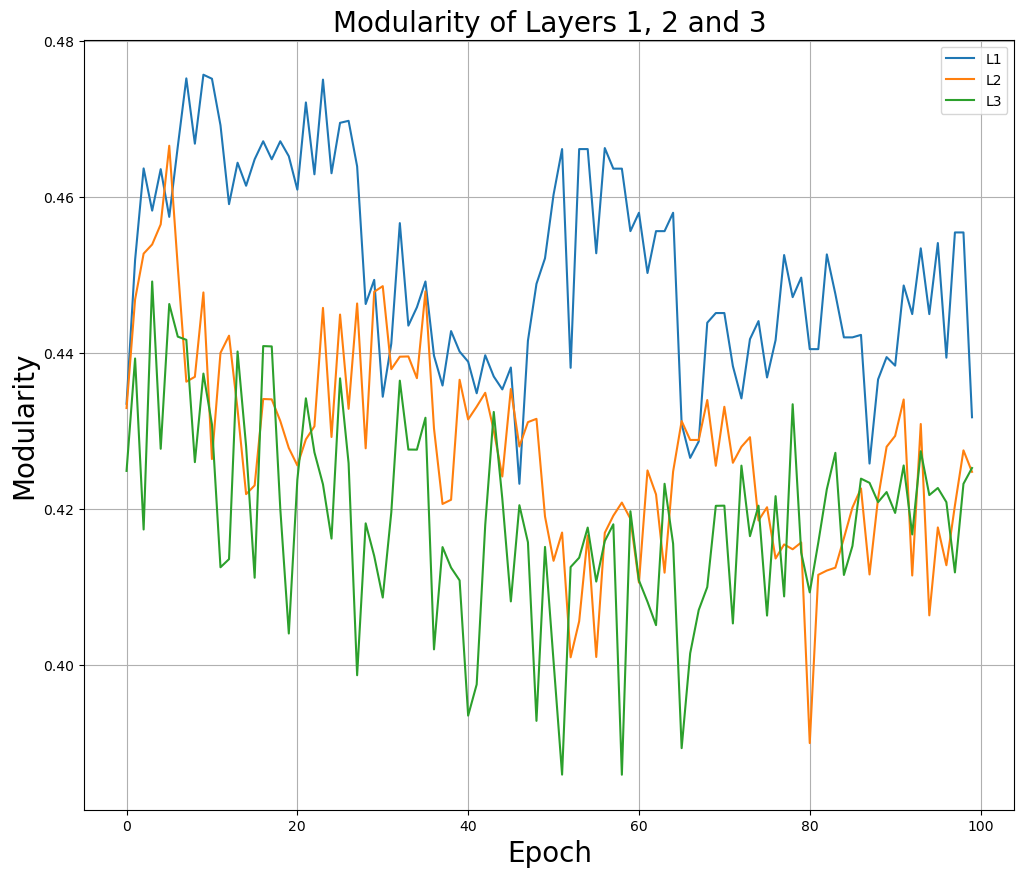

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer1)
plt.plot(modularity_layer2)
plt.plot(modularity_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layers 1, 2 and 3", fontsize = 20)
plt.legend(['L1', 'L2', 'L3'])
plt.grid(True)
plt.show()

# Number of Communities for layers in every epoch

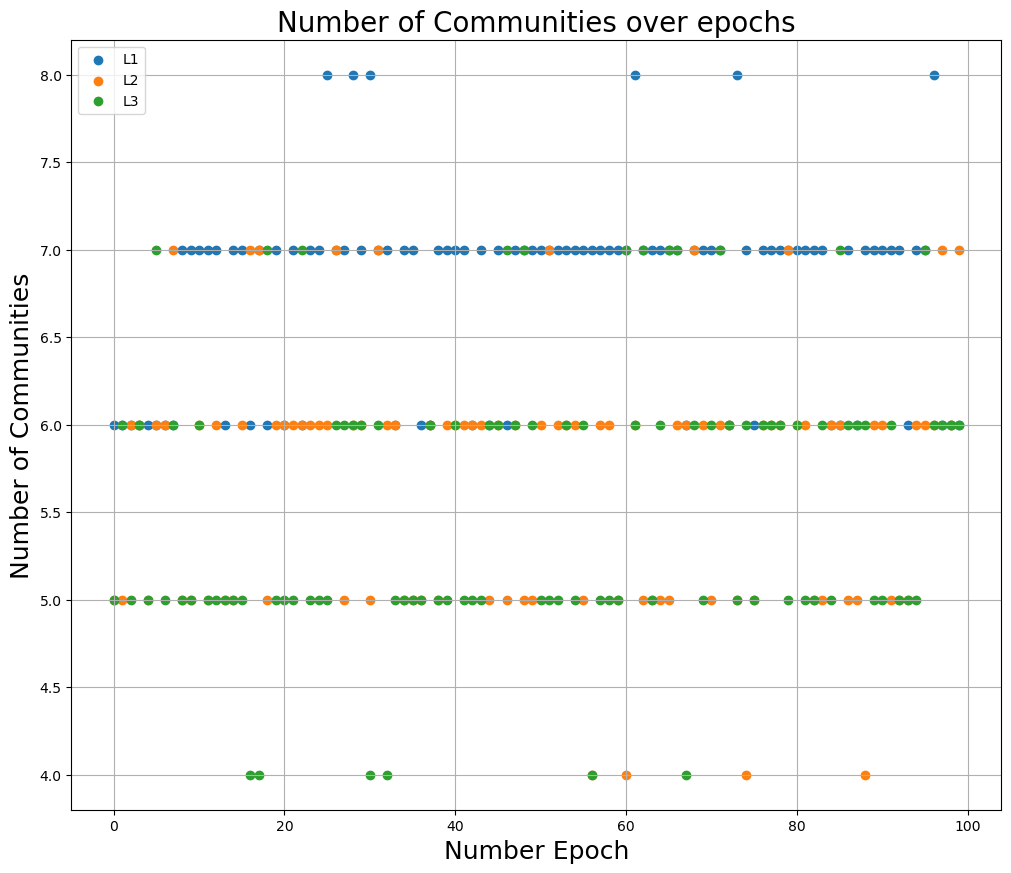

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(range(100), communities_layer1)
plt.scatter(range(100), communities_layer2)
plt.scatter(range(100), communities_layer3)
plt.xlabel('Number Epoch', fontsize = 18)
plt.ylabel('Number of Communities', fontsize = 18)
plt.title('Number of Communities over epochs', fontsize= 20)
plt.legend(['L1', 'L2', 'L3'])
plt.grid(True)
plt.show()

# Mann Whitney Test 

In [ ]:
from scipy.stats import mannwhitneyu 

In [ ]:
statistic_12, pvalue_12 = mannwhitneyu(modularity_layer1, modularity_layer2, alternative = 'two-sided')
if pvalue_12 <= 0.05:
    print("Reject Null Hypothesis \nThat is: The means are not equal")
else:
    print("Accept Null Hypothesis \nThat is: The means are equal")
print("Pvalue: " + str(pvalue_12))

Reject Null Hypothesis 
That is: The means are not equal
Pvalue: 1.8824902509784717e-22


In [ ]:
statistic_23, pvalue_23 = mannwhitneyu(modularity_layer2, modularity_layer3, alternative = 'two-sided')
if pvalue_23 <= 0.05:
    print("Reject Null Hypothesis \nThat is: The means are not equal")
else:
    print("Accept Null Hypothesis \nThat is: The means are equal")
print("Pvalue: " + str(pvalue_23))

Reject Null Hypothesis 
That is: The means are not equal
Pvalue: 2.730869259099845e-06


In [ ]:
statistic_31, pvalue_31 = mannwhitneyu(modularity_layer3, modularity_layer1, alternative = 'two-sided')
if pvalue_31 < 0.05:
    print("Reject Null Hypothesis \nThat is: The means are not equal")
else:
    print("Accept Null Hypothesis \nThat is: The means are equal")
print("Pvalue: " + str(pvalue_31))

Reject Null Hypothesis 
That is: The means are not equal
Pvalue: 7.556113150233069e-30


# Statistical Test of Modularities btw L1 and L2

In [ ]:
# Man - Whitney Test 
# Threshold - 0.5 
